In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from collections import OrderedDict
import pickle
from datetime import datetime
from sklearn.metrics import classification_report, roc_curve, precision_recall_curve,roc_auc_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb

In [6]:
TLC_df = pd.read_csv('data\\TLC_df_final.csv')

In [7]:
df_fico_grade = pd.read_csv('data\\grade_to_fico.csv')
df_fico_grade.head()

,sub_grade,score,value
0,A1,789,34
1,A2,780,33
2,A3,769,32
3,A4,761,31
4,A5,741,30


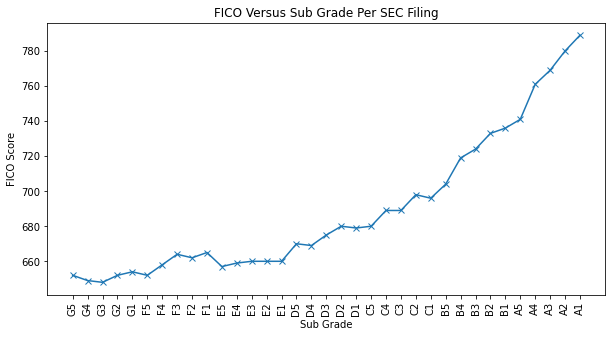

In [8]:
plt.figure(figsize=(10,5))
plt.plot(df_fico_grade['value'], df_fico_grade['score '], marker='x')
plt.xticks(range(df_fico_grade.shape[0]) , df_fico_grade['sub_grade'][::-1], rotation='vertical')
plt.xlabel('Sub Grade')
plt.ylabel("FICO Score")
plt.title("FICO Versus Sub Grade Per SEC Filing")
plt.savefig(os.path.join('fico_grade_line.png'))
plt.show()

In [9]:
#instantiate regressor
knn = KNeighborsRegressor(n_neighbors=1)
#fit to data
knn.fit(np.reshape(df_fico_grade['score '].values, (-1, 1)), 
        df_fico_grade['value'])
#make sample prediction
sub_grade_pred = knn.predict(np.reshape([800], (1,-1)))[0]
sub_grade_pred

34.0

In [10]:
#save the model
#with open(os.path.join('/content/drive/MyDrive/knn_regression.pkl'), 'wb') as handle:
 #   pickle.dump(knn,handle)

In [11]:
df_fico_apr = pd.read_csv('data\\grade_to_apr.csv')
df_fico_apr.head()

,grade_num,loan_grade,apr,36_mo,60_mo
0,34,A1,6.03,6.78,7.30
1,33,A2,6.97,7.99,8.26
2,32,A3,7.62,8.99,8.91
3,31,A4,8.60,9.98,9.91
4,30,A5,9.25,10.99,10.56


In [12]:
df_fico_apr[df_fico_apr['grade_num']==sub_grade_pred]['36_mo']

0    6.78
Name: 36_mo, dtype: float64

In [13]:
target = 'loan_status'


X = TLC_df.drop(columns=[target,'zip_3','zip_2','Unnamed: 0'], axis=1)
y = TLC_df[target]

In [14]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3, random_state=11)

In [15]:
drop_columns=['pub_rec','pub_rec_bankruptcies','purpose','revol_bal','total_acc']

In [16]:
X_train=X_train.drop(columns=drop_columns)
X_test =X_test.drop(columns=drop_columns)

In [17]:
X_train.head()

,loan_amnt,funded_amnt,term,int_rate,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,dti,open_acc,revol_util,mort_acc,credit_hist,fico_avg_score,inst_amnt_ratio
80245,12000.0,12000.0,1,7.26,7,31,2.0,3,65000.0,0,28.99,11.0,51.3,0.0,5052.0,712.0,0.030997
70177,8400.0,8400.0,1,17.57,4,16,6.0,3,20000.0,2,22.03,5.0,64.8,0.0,2648.0,687.0,0.035938
760935,7000.0,7000.0,1,15.61,4,19,9.0,4,36000.0,2,38.70,11.0,29.1,1.0,12815.0,692.0,0.034966
325461,15225.0,15225.0,2,19.52,3,12,10.0,3,110000.0,2,8.40,6.0,43.3,0.0,11354.0,677.0,0.026228
1267091,10000.0,10000.0,1,13.99,5,22,3.0,3,125000.0,1,10.41,10.0,78.1,0.0,4506.0,682.0,0.034173


In [37]:
from collections import Counter
counter = Counter(y_train)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)
clf = xgb.XGBClassifier(n_estimators=300,
                            subsample=0.9,
                            n_jobs=-1,
                            max_depth=6,
                            eta=0.05,
                           scale_pos_weight=estimate)

clf.fit(X_train, y_train)

#make predictions
y_pred = clf.predict(X_test)
confusion_matrix(y_test, y_pred)
#'xgb__colsample_bytree': 0.9, 'xgb__eta': 0.05, 'xgb__max_depth': 6

Estimate: 3.551


C:\Users\lenovo\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:03:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


array([[196040, 109159],
       [ 27153,  58236]], dtype=int64)

In [38]:
fpr, tpr, thresholds = roc_curve(y_test,clf.predict_proba(X_test)[:,1],pos_label=1)

In [39]:
precision, recall, thresholds = precision_recall_curve(y_test,
                                                       clf.predict_proba(X_test)[:,1],
                                                       pos_label=1)

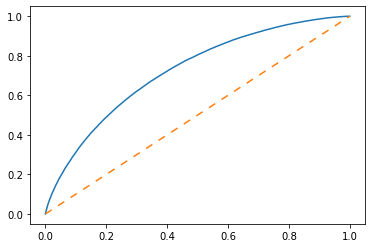

In [40]:
plt.plot(fpr, tpr, label='XGB')
plt.plot([0,1], [0,1], label='No Discrimination', linestyle='-', dashes=(5, 5))
plt.show()

In [41]:
xgb_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
print("xgb_auc: {}".format(xgb_auc))

xgb_auc: 0.7228401827404558


In [42]:
f1_xgb = f1_score(y_test, y_pred)

print("f1_xgb (binary): {}\n".format(f1_xgb))
print(classification_report(y_test,y_pred))

f1_xgb (binary): 0.46075700993733787

              precision    recall  f1-score   support

           0       0.88      0.64      0.74    305199
           1       0.35      0.68      0.46     85389

    accuracy                           0.65    390588
   macro avg       0.61      0.66      0.60    390588
weighted avg       0.76      0.65      0.68    390588



In [43]:
#define location to save trained model
save_model_dir = os.path.join('xgb.pkl')
print("Saving model at: {}".format(save_model_dir))

#save the model
with open(save_model_dir, 'wb') as handle:
    pickle.dump(clf,
                handle)


Saving model at: xgb.pkl


In [43]:
# load the model
with open('models\\xgb.pkl', 'rb') as f:
    clf = pickle.load(f)

In [44]:
TLC_df.head()

,Unnamed: 0,loan_amnt,funded_amnt,term,int_rate,grade,sub_grade,emp_length,home_ownership,annual_inc,...,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies,zip_3,zip_2,credit_hist,fico_avg_score,inst_amnt_ratio
0,0,3600.0,3600.0,1,13.99,5,21,10.0,4,55000.0,...,2765.0,29.7,13.0,1.0,0.0,190,19,4505.0,677.0,0.034175
1,1,24700.0,24700.0,1,11.99,5,24,10.0,4,65000.0,...,21470.0,19.2,38.0,4.0,0.0,577,57,5844.0,717.0,0.033210
2,4,10400.0,10400.0,2,22.45,2,9,3.0,4,104433.0,...,21929.0,64.5,35.0,6.0,0.0,174,17,6392.0,697.0,0.027876
3,5,11950.0,11950.0,1,13.44,5,22,4.0,3,34000.0,...,8822.0,68.4,6.0,0.0,0.0,300,30,10288.0,692.0,0.033906
4,6,20000.0,20000.0,1,9.17,6,28,10.0,4,180000.0,...,87329.0,84.5,27.0,4.0,0.0,550,55,9314.0,682.0,0.031879


In [18]:
CATEGORIES = ["LOAN ISSUED","LOAN DENIED"]

In [19]:
#instantiate regressor
knn_fa = KNeighborsRegressor(n_neighbors=1)
#fit to data
knn_fa.fit(np.reshape(X_train['loan_amnt'].values, (-1, 1)), 
        X_train['funded_amnt'])

KNeighborsRegressor(n_neighbors=1)

In [46]:
#get input for issue
fico = 677
loan_amnt = 3600
term = '36 months'
dti = 5.91
home_ownership = 'MORTGAGE'
mort_acc = 1
annual_inc = 55000
open_acc = 12
employment_length = 10
verification_status = 0
revol_util = 29.7
total_acc = 13
credit_hist = 4505

In [32]:
#get input for deny
fico = 662
loan_amnt = 24000
term = '60 months'
dti = 18.30
home_ownership = 'rent'
mort_acc = 2
annual_inc = 110000
open_acc = 10
employment_length = 6
verification_status = 0
revol_util = 68.1
mort_acc = 31
credit_hist = 6302

In [33]:
funded_amnt = knn_fa.predict(np.reshape([loan_amnt], (1,-1)))[0]
funded_amnt

24000.0

In [34]:
#calculate grade from FICO
sub_grade = knn.predict(np.reshape([fico], (1,-1)))[0]
#calculate grade
grade = round(sub_grade/5) + 1
#get interest rate
apr_row = df_fico_apr[df_fico_apr['grade_num']==sub_grade]

In [35]:
if term=='36 months':
    int_rate = apr_row['36_mo'].values[0]
    installment = float(loan_amnt)/36
            
else:
    int_rate = apr_row['60_mo'].values[0]
    installment = float(loan_amnt)/60

In [36]:
term_to_int = {'36 months': 1, '60 months': 2}
home_to_int = {'MORTGAGE': 4, 'RENT': 3, 'OWN': 5,'ANY': 2,'OTHER': 1, 'NONE':0 }

In [37]:
temp = pd.DataFrame(index=[1])
temp['loan_amnt']=loan_amnt
temp['funded_amnt']=funded_amnt
temp['term']=term_to_int[term]
temp['int_rate']=int_rate
temp['grade']=grade
temp['sub_grade']=sub_grade
temp['emp_length']=employment_length
temp['home_ownership']=home_to_int[home_ownership.upper()]
temp['annual_inc']=annual_inc
temp['verification_status']=verification_status
temp['dti']=dti
temp['open_acc'] = open_acc
temp['revol_util']=revol_util
temp['mort_acc'] = mort_acc
temp['credit_hist']=credit_hist
temp['fico_avg_score'] = fico
temp['inst_amnt_ratio']=installment/loan_amnt

In [38]:
X_train.columns

Index(['loan_amnt', 'funded_amnt', 'term', 'int_rate', 'grade', 'sub_grade',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'dti', 'open_acc', 'revol_util', 'mort_acc', 'credit_hist',
       'fico_avg_score', 'inst_amnt_ratio'],
      dtype='object')

In [39]:
temp.columns

Index(['loan_amnt', 'funded_amnt', 'term', 'int_rate', 'grade', 'sub_grade',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'dti', 'open_acc', 'revol_util', 'mort_acc', 'credit_hist',
       'fico_avg_score', 'inst_amnt_ratio'],
      dtype='object')

In [40]:
temp

,loan_amnt,funded_amnt,term,int_rate,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,dti,open_acc,revol_util,mort_acc,credit_hist,fico_avg_score,inst_amnt_ratio
1,24000,24000.0,2,26.27,3,8.0,6,3,110000,0,18.3,10,68.1,31,6302,662,0.016667


In [41]:
Result = clf.predict(temp)
print(CATEGORIES[int(Result)])

LOAN DENIED
